This MDP is the model of skill acquisition, not the object level (game level) MDP.
$$M_{skill} = (S, A, T, \gamma, r)$$

#### State

The state $S$ contains 2 skills, and $m$ means the there are m subskills to accomplish one skill. It means, if the skill is totally learned, $\frac{m}{k} = 1$,  

$$S = \{(d_1, d_2):  d_1 \in \{0, 1, ..., (nS_1 - m_1)\}, d_2 \in \{0, 1, ..., (nS_2 - m_2)\}, m_1 \in \{1, 2, ..., nS_1\}, m_2 \in \{1, 2, ..., nS_2\}\}$$


where $nS_1$ and $nS_2$ mean the possible solutions of the skill 1 and skill 2 respectively.

$d_1$ and $d_2$ mean eliminated wrong solutions of the skill1 and skill 2 resprectively. 

$m1$ and $m2$ describtes the number of right solutions of skill 1 and skill 2. (This could also indicate there are $m_1$ combined sub-skills to complish the skill 1, and so is $m_2$ for skill 2.?)
for the sake of simplificaiton, $m_1$ and $m_2$ are set to 1 in the following text. 

#### Action
The action space is $$A = {1, 2}$$ means to choose to learn or use skill 1 or 2.

#### Transition probability
The transition function: the probability of choosing action 1 and the next state being $(nS_1 - 1, d2)$ is $\frac{1}{nS_1-d_1}$, when the agent successfully achieve skill 1. 
If the agent tried one key out without success, the probability of choosing action 1 and the next state being $(d_1+1, d2)$ is $1 - \frac{1}{nS_1-d_1}$:


$$P( s_{t+1} = (nS_1 - 1, d_2)|s_t = (d_1, d_2), a=1) = \frac{1}{nS_1-d_1}$$

$$P(s_{t+1} = (d_1 + 1, d_2)| s_t = (d_1, d_2), a=1) = 1 - \frac{1}{nS_1-d_1}$$

$$P(s_{t+1} = (d_1, nS_2 - 1)| s_t = (d_1, d_2), a=2) = \frac{1}{nS_2-d_2}$$

$$P(s_{t+1} = (d_1, d_2 + 1)| s_t = (d_1, d_2), a=2) = 1 - \frac{1}{nS2-d_2}$$

#### Rewards
The reward function:

$$r((d_1, d_2), 1, (nS_1 - 1, d_2)) = g -d(objd)$$

$$r((d_1, d_2), 1, (d_1 + 1, d_2)) = -1$$

$$r((d_1, d_2), 2, (d_1, nS_2 - 1)) = g$$

$$r((d_1, d_2), 2, (d_1, d_2 + 1)) = -1$$

#### Action Value of Practice:
$Q_p$ is the action value of practice

$$Q_p((d_1, d_2), 1) = \frac{1}{nS_1 - d_1}((g) + \gamma V(nS1-1, d_2)) + (1 - \frac{1}{nS_1-d_1})(-1 + \gamma V(d_1 +1, d_2)) - Q_s((d_1, d_2), 1)$$

the formular describes the action value of practice $Q_p$ at the state $(d_1, d_2)$ with the action 1.

$$Q_p((d_1, d_2), 2) = \frac{1}{nS_2 - d_2}((g) + \gamma V(d_1, nS_2 - 1)) + (1 - \frac{1}{nS_2-d_2})(-1 + \gamma V(d_1, d_2 + 1)) - Q_s((d_1, d_2), 2)$$

the action value of practices $Q_p$ at the state $(d_1, d_2)$ with the action 2.

#### Action Value of Skill:

$$Q_s((d_1, d_2), 1) = g\lfloor{\frac{1}{(1-\gamma)(d_1 + 1)}}\rfloor - \frac{1}{1- \gamma}$$

$$Q_s((d_1, d_2), 2) = g\lfloor{\frac{1}{(1-\gamma)(d_2 + 1)}}\rfloor - \frac{1}{1- \gamma}$$

In [106]:
import numpy as np

In [107]:
# parameters
nS1 = 27 # the number of possible solutions of skill 1
nS2 = 20 # the number of possible solutions of skill 1
g = 100 # goal
gamma = 0.9 # discount factor
states = [(x, y) for x in range(nS1) for y in range(nS2)]
actions = [1, 2]

In [108]:
# The next states given current state
def step(cur_state):
    d1, d2 = cur_state
    
    if d1 < (nS1 - 1) and d2 < (nS2 - 1):
        next_states = [(d1+1, d2),(d1, d2+1)]
        
    elif d1 == (nS1 - 1) and d2 != (nS2 - 1):
        next_states = [(d1, d2), (d1, d2+1)]
        
    elif d1 != (nS1 - 1) and d2 == (nS2 - 1):
        next_states = [(d1+1, d2), (d1, d2)]
        
    elif d1 == (nS1 - 1) and d2 == (nS2 - 1):
        next_states = [(d1, d2), (d1, d2)]
        
    return next_states  

In [109]:
# return action value of skills
def skill_action_value(state, g, gamma):
    d1, d2 = state
    q_s_values = [(g*np.floor(1/((1-gamma)*(d1 + 1))) - 1/(1-gamma)), (g*np.floor(1/((1-gamma)*(d2 + 1))) - 1/(1-gamma))]
    return q_s_values

In [110]:
# return the converged value function of given policy
def policy_evaluation(policy, gamma, vos, v_sequence):
    
    V = {} 
    for state in states:
        V[state] = 0
    
    iteration = 0
    while True:
        delta = 0
        
        for state in states:
            d1, d2 = state
            v = 0
            action_prob1 = policy[state][0]
            action_prob2 = policy[state][1]
#             print("action_probs: {}, {}".format(action_prob1, action_prob2))
            next_states = step(state)
            q_s_values = skill_action_value(state, g, gamma)
            if vos:
                v = action_prob1 * \
                            ((1/(nS1 - d1))*((g) + gamma*V[(nS1-1, d2)]) +\
                             (1 - 1/(nS1 - d1))*(-1 + gamma*V[next_states[0]]) - \
                             q_s_values[0]) +\
                    action_prob2 * \
                            ((1/(nS2 - d2))*((g) + gamma*V[(d1, nS2-1)]) +\
                             (1 - 1/(nS2 - d2))*(-1 + gamma*V[next_states[1]]) - \
                            q_s_values[1])
            else:
                v = action_prob1 * \
                            ((1/(nS1 - d1))*((g) + gamma*V[(nS1-1, d2)]) +\
                             (1 - 1/(nS1 - d1))*(-1 + gamma*V[next_states[0]])) +\
                    action_prob2 * \
                            ((1/(nS2 - d2))*((g) + gamma*V[(d1, nS2-1)]) +\
                             (1 - 1/(nS2 - d2))*(-1 + gamma*V[next_states[1]]))
                
            delta = max(delta, np.abs(V[state] - v))
            V[state] = v
        
        v_sequence.append(V.copy())
        iteration += 1
#         print("delta: {}".format(delta))
        if delta < 1e-4:
            print("iteration: {}".format(iteration))
            print("number of changed V: {}".format(len(v_sequence)))
#             print(v_sequence[0])
#             print(v_sequence[1])
            break
    return V

In [111]:
# return the action values given current states
def one_step_lookahead(state, V, gamma, vos):
    d1, d2 = state
    A = np.zeros(len(actions))
    next_states = step(state)
    q_s_values = skill_action_value(state, g, gamma)
    
    for action in range(len(A)):
        if action == 0:
            if vos:
                A[action] = (1/(nS1 - d1))*((g) + gamma*V[(nS1-1, d2)]) +\
                            (1 - 1/(nS1 - d1))*(-1 + gamma*V[next_states[0]]) - \
                            q_s_values[0]
            else:
                A[action] = (1/(nS1 - d1))*((g) + gamma*V[(nS1-1, d2)]) +\
                            (1 - 1/(nS1 - d1))*(-1 + gamma*V[next_states[0]])
                
        elif action == 1:
            if vos:
                A[action] = (1/(nS2 - d2))*((g) + gamma*V[(d1, nS2-1)]) +\
                            (1 - 1/(nS2 - d2))*(-1 + gamma*V[next_states[1]]) -\
                            q_s_values[1]
            else:
                A[action] = (1/(nS2 - d2))*((g) + gamma*V[(d1, nS2-1)]) +\
                            (1 - 1/(nS2 - d2))*(-1 + gamma*V[next_states[1]])
                
        else:
            raise ValueError
    return A       

In [112]:
# policy improvement, return optimal policy, optimal state value and the 
# sequence of all state values during the iteration
def policy_iteration(gamma, vos=True):
    policy = {} 
    for state in states: 
        policy[state] = np.ones(len(actions))/len(actions)

    v_sequence = []
    
    while True:
        
        V = policy_evaluation(policy, gamma, vos, v_sequence)

        policy_stable = True
        policy_change = 0
        
        for state in states:
            chosen_a = np.argmax(policy[state])
            action_values = one_step_lookahead(state, V, gamma, vos)
#             print("action_values: {}".format(action_values))
            best_action = np.argmax(action_values)
            if best_action != chosen_a:
                policy_change += 1
                policy_stable = False
            policy[state] = np.eye(len(actions))[best_action]
        print("policy change in {} states".format(policy_change))
        if policy_stable:
            return policy, V, v_sequence

In [113]:
# reshape the returns from policy iteration to the gridworld-like shape
def reshape_optimal(vos, gamma, nS1, nS2, policy_improve=policy_iteration):
    policy, V, v_sequence = policy_improve(gamma, vos)
    optimal_policy = np.zeros((nS1, nS2))
    optimal_V = np.zeros((nS1, nS2))
    for state, action_values in policy.items():
        d1, d2 = state
        optimal_policy[d1, d2] = np.argmax(action_values)
        optimal_V[d1, d2] = V[state]
    return np.array(optimal_policy), np.array(optimal_V), v_sequence

In [129]:
optimal_policy, optimal_V, v_sequence = reshape_optimal(False, gamma, nS1, nS2)

iteration: 133
number of changed V: 133
policy change in 330 states
iteration: 133
number of changed V: 266
policy change in 0 states


In [130]:
optimal_V

array([[433.6029686 , 449.76969312, 466.8905227 , 485.03474672,
        504.27727975, 524.69915023, 546.3880336 , 569.43883404,
        593.9543193 , 620.04581367, 647.83395467, 677.44951929,
        709.03432654, 742.74222345, 778.7401625 , 817.20937917,
        858.34667917, 902.36584584, 949.49917917, 999.99917917],
       [433.6029686 , 449.76969312, 466.8905227 , 485.03474672,
        504.27727975, 524.69915023, 546.3880336 , 569.43883404,
        593.9543193 , 620.04581367, 647.83395467, 677.44951929,
        709.03432654, 742.74222345, 778.7401625 , 817.20937917,
        858.34667917, 902.36584584, 949.49917917, 999.99917917],
       [433.6029686 , 449.76969312, 466.8905227 , 485.03474672,
        504.27727975, 524.69915023, 546.3880336 , 569.43883404,
        593.9543193 , 620.04581367, 647.83395467, 677.44951929,
        709.03432654, 742.74222345, 778.7401625 , 817.20937917,
        858.34667917, 902.36584584, 949.49917917, 999.99917917],
       [433.6029686 , 449.76969312, 4

In [115]:
optimal_policy[0, 19]

1.0

In [116]:
optimal_policy_vos, optimal_V_vos, v_sequence_vos = reshape_optimal(True, gamma, nS1, nS2)

iteration: 134
number of changed V: 134
policy change in 273 states
iteration: 134
number of changed V: 268
policy change in 3 states
iteration: 134
number of changed V: 402
policy change in 0 states


### 2D Visualization
plots of the optimal policy and optimal V with and without value of skills, respectively

In [117]:
%matplotlib inline

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

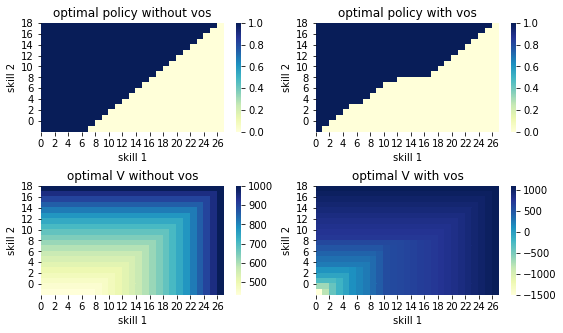

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5))
plt.subplots_adjust(hspace=0.5, right=1)

data = [optimal_policy, optimal_policy_vos, optimal_V, optimal_V_vos]
titles = ["optimal policy without vos", "optimal policy with vos", "optimal V without vos", "optimal V with vos"]
for i, ax in enumerate(axs.flatten()):
    fig = sns.heatmap(np.rot90(data[i]), cmap="YlGnBu", ax=ax)
    fig.set_title(titles[i])
    fig.set_xlabel("skill 1")
    fig.set_ylabel("skill 2")
    fig.set_xticks(list(range(0, nS1, 2)))
    fig.set_yticks(list(reversed(range(0, nS2, 2))))
    
# TODO: check the formular and correct them, adjust the states, explain the d1, d2, change the probabilities formulations!!!!

### 3D Visualization

In [120]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

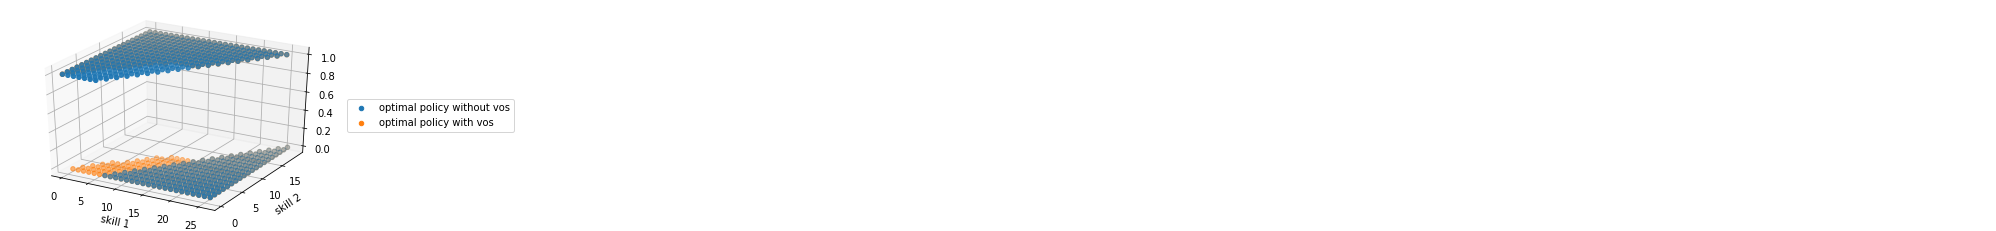

In [122]:
# 3d plots for optimal policy with and without vos
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.set_yticks(list(reversed(range(0, nS2, 5))))
ax.set_xlabel("skill 1")
ax.set_ylabel("skill 2")
x = np.arange(nS1)
y = np.arange(nS2)
x, y = np.meshgrid(x, y)
z1 = optimal_policy.T
z2 = optimal_policy_vos.T
scatter1 = ax.scatter(x, y, z1, label="optimal policy without vos")
scatter2 = ax.scatter(x, y, z2, label="optimal policy with vos")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 0.92, 'optimal V')

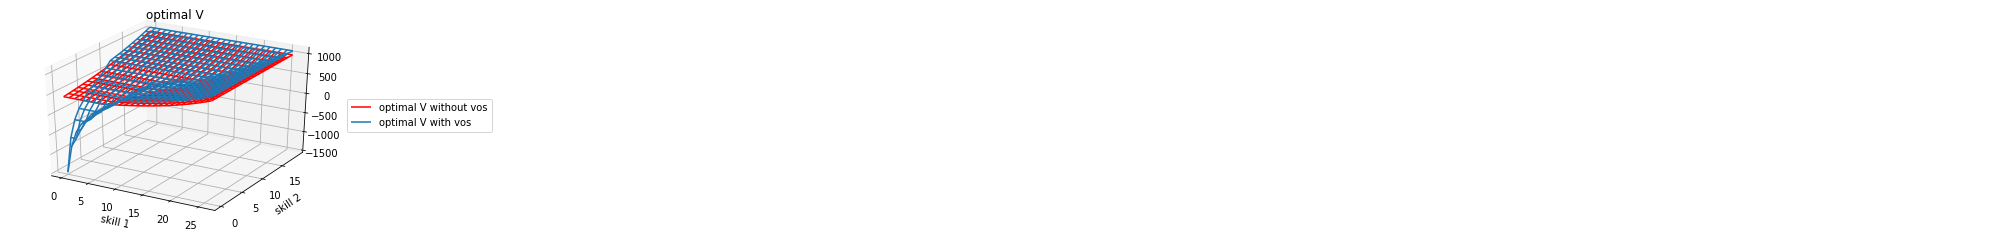

In [124]:
# 3d plots for 

fig = plt.figure(figsize=(6, 4))
ax = fig.gca(projection='3d')
ax.set_yticks(list(reversed(range(0, nS2, 5))))
ax.set_xlabel("skill 1")
ax.set_ylabel("skill 2")


x = np.arange(nS1)
y = np.arange(nS2)
x, y = np.meshgrid(x, y)

z1 = optimal_V.T
z2 = optimal_V_vos.T

wireframe1 = ax.plot_wireframe(x, y, z1, color= "red", label="optimal V without vos")
wireframe2 = ax.plot_wireframe(x, y, z2, label="optimal V with vos")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("optimal V")

### animated value states

In [125]:
import matplotlib.animation as animation
from IPython.display import HTML

In [126]:
v_sequence_snippet = v_sequence
# v_sequence_snippet = v_sequence_vos

In [127]:
v_sequence_reshape = []
_v = np.zeros((nS1, nS2))
for v in v_sequence_snippet:
    for state, value in v.items():
        d1, d2 = state
        _v[d1, d2] = value
    v_sequence_reshape.append(_v.copy())

shape state value in the sequence: (27, 20)


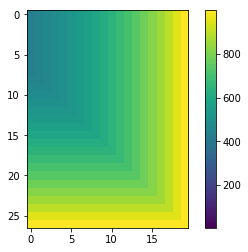

In [128]:
fig = plt.figure()


def f(i):
    return v_sequence_reshape[i]

i = 0

print("shape state value in the sequence: {}".format(f(i).shape))

vmin = min(np.min(seq) for seq in v_sequence_reshape)
vmax = max(np.max(seq) for seq in v_sequence_reshape)


im = plt.imshow(f(i), animated=True, vmin=vmin, vmax=vmax)
plt.colorbar()


def updatefig(i):
    im.set_array(f(i))
    return im,

ani = animation.FuncAnimation(fig, updatefig, len(v_sequence_reshape) - 1, interval=50, blit=True)
HTML(ani.to_html5_video())